# Test Scores and Model Diagnostics

Legend
* Get analysis results using hold-out test set on each model and variable, including SHAP

In [ ]:
#background.to_csv('cleaned_background.csv', index=True)
background = pd.read_csv('cleaned_background.csv')

background.set_index('challengeID', inplace=True)

In [ ]:
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)
test = pd.read_csv('FFChallenge_v5/test.csv', sep=',', header=0, index_col=0)



# GPA

## Elastic

In [ ]:
model = joblib.load('models/gpa_el_500.pkl')

In [ ]:
model.best_params_

{'model__regressor__preprocess__strategy': 'median',
 'model__regressor__elastic__l1_ratio': 0.20999999999999996,
 'model__regressor__elastic__alpha': 1000}

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000, l1_ratio=0.2, alpha=1000.0)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='median')), ('scaler', 'passthrough'), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])


In [ ]:
elastic_fit = model_pipe.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_pred = elastic_fit.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

0.3857494061289718

In [ ]:
r2_score(y_test,y_pred)

0.08667317030809574

## Random Forest

In [ ]:
model = joblib.load('models/gpa_rf_rs200_model.pkl')

In [ ]:
model.best_params_

{'model__regressor__sel__k': 10000,
 'model__regressor__randomforest__n_estimators': 253,
 'model__regressor__randomforest__min_samples_split': 26,
 'model__regressor__randomforest__min_samples_leaf': 5,
 'model__regressor__randomforest__max_features': 'auto',
 'model__regressor__randomforest__max_depth': 27,
 'model__regressor__preprocess__strategy': 'mean'}

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rf = RandomForestRegressor(random_state=0, 
                           n_estimators=253, 
                           min_samples_split=26, 
                           min_samples_leaf=5, 
                           max_features='auto', 
                          max_depth=27)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k=10000)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), 
                           ('normalize', StandardScaler()),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
random_forest = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_pred = random_forest.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

0.35164833590418565

In [ ]:
r2_score(y_test,y_pred)

0.1674132099883947

## Gradient Boosting

In [ ]:
model = joblib.load('models/gpa_xgb_200_.pkl')

In [ ]:
model.best_params_

{'model__regressor__xgboost__subsample': 0.5000000000000001,
 'model__regressor__xgboost__n_estimators': 160,
 'model__regressor__xgboost__min_child_weight': 6,
 'model__regressor__xgboost__max_depth': 7,
 'model__regressor__xgboost__learning_rate': 0.02100000000000001,
 'model__regressor__xgboost__gamma': 0.19,
 'model__regressor__xgboost__colsample_bytree': 0.8000000000000003,
 'model__regressor__xgboost__colsample_bylevel': 1.0,
 'model__regressor__sel__k': 13110,
 'model__regressor__normalize': RobustScaler(),
 'model__regressor__impute__strategy': 'median'}

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k = 13110)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.5, 
                          n_estimators=160, 
                         min_child_weight=6,
                         max_depth=7,
                         learning_rate = 0.02,
                         gamma = 0.19, 
                         colsample_bytree = 0.8, 
                         colsample_bylevel = 1.0)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')), ('normalize', RobustScaler()), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
boosting = model_pipe.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_pred = boosting.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

In [ ]:
r2_score(y_test,y_pred)

0.18412109625667683

### SHAP

In [ ]:
import shap

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)

#minmaxscaler on X_values
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.5, 
                          n_estimators=160, 
                         min_child_weight=6,
                         max_depth=7,
                         learning_rate = 0.02,
                         gamma = 0.19, 
                         colsample_bytree = 0.8, 
                         colsample_bylevel = 1.0)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
xg_reg.fit(X_train, y_train_trans)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.19, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=7,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=160, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
mybooster = xg_reg.get_booster()    

In [ ]:
model_bytearray = mybooster.save_raw()[4:]

In [ ]:
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [ ]:
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


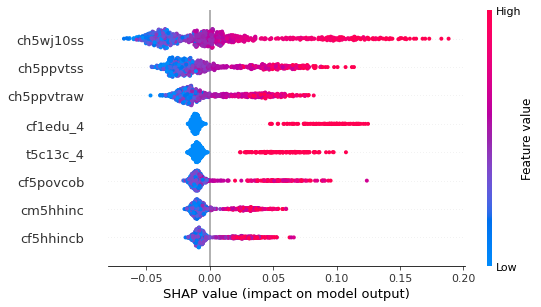

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

# Grit

## Elastic

In [ ]:
model = joblib.load('models/grit_el_200.pkl')

In [ ]:
model.best_params_

{'model__regressor__scaler': RobustScaler(),
 'model__regressor__preprocess__strategy': 'median',
 'model__regressor__elastic__l1_ratio': 0.9099999999999996,
 'model__regressor__elastic__alpha': 1400}

In [ ]:
variable = 'grit'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000, l1_ratio=0.9, alpha=1400.0)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='median')), ('scaler', 'passthrough'), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])


In [ ]:
grit_elastic = model_pipe.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
grit_pred_elastic = grit_elastic.predict(X_test)

In [ ]:
mean_squared_error(y_test,grit_pred_elastic)

0.2515700337325141

In [ ]:
r2_score(y_test,grit_pred_elastic)

0.005350114140940443

## Random Forest 

In [ ]:
model = joblib.load('models/gpa_rf_rs200_model.pkl')

In [ ]:
model.best_params_

{'model__regressor__scaler': RobustScaler(),
 'model__regressor__preprocess__strategy': 'median',
 'model__regressor__elastic__l1_ratio': 0.9099999999999996,
 'model__regressor__elastic__alpha': 1400}

In [ ]:
variable = 'gpa'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rf = RandomForestRegressor(random_state=0, 
                           n_estimators=253, 
                           min_samples_split=26, 
                           min_samples_leaf=5, 
                           max_features='auto', 
                          max_depth=27)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k=10000)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), 
                           ('normalize', StandardScaler()),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
random_forest = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_pred = random_forest.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred)

0.35164833590418565

In [ ]:
r2_score(y_test, y_pred)

0.1674132099883947

## Gradient Boosting

In [ ]:
model = joblib.load('models/grit_xgb_200_.pkl')

In [ ]:
model.best_params_

{'model__regressor__xgboost__subsample': 0.7000000000000002,
 'model__regressor__xgboost__n_estimators': 130,
 'model__regressor__xgboost__min_child_weight': 2,
 'model__regressor__xgboost__max_depth': 6,
 'model__regressor__xgboost__learning_rate': 0.01850000000000001,
 'model__regressor__xgboost__gamma': 1.6600000000000001,
 'model__regressor__xgboost__colsample_bytree': 0.3,
 'model__regressor__xgboost__colsample_bylevel': 1.0,
 'model__regressor__sel__k': 910,
 'model__regressor__normalize': RobustScaler(),
 'model__regressor__impute__strategy': 'median'}

In [ ]:
variable = 'grit'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k = 5000)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.7, 
                          n_estimators=130, 
                         min_child_weight=2,
                         max_depth=6,
                         learning_rate = 0.018,
                         gamma = 1.66, 
                         colsample_bytree = 0.3, 
                         colsample_bylevel = 1.0)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='median')), ('normalize', RobustScaler()), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
boosting = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
grit_boosing_pred = boosting.predict(X_test)

In [ ]:
mean_squared_error(y_test,grit_boosing_pred)

0.2381845612902674

In [ ]:
r2_score(y_test, grit_boosing_pred)

0.058273184664540234

In [ ]:
import shap

In [ ]:
variable = 'grit'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)


#minmaxscaler on X_values
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.7, 
                          n_estimators=130, 
                         min_child_weight=2,
                         max_depth=6,
                         learning_rate = 0.018,
                         gamma = 1.66, 
                         colsample_bytree = 0.3, 
                         colsample_bylevel = 1.0)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
xg_reg.fit(X_train, y_train_trans)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=0.3, gamma=1.66, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.018, max_delta_step=0, max_depth=6,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=130, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
mybooster = xg_reg.get_booster()    

In [ ]:
model_bytearray = mybooster.save_raw()[4:]

In [ ]:
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [ ]:
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


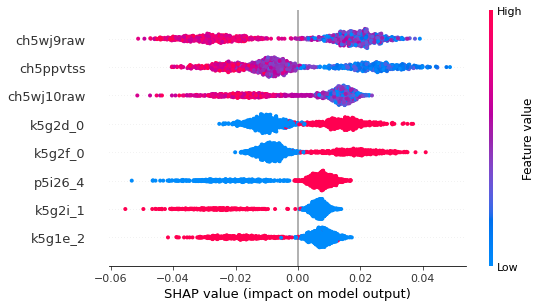

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8, )

# Material Hardship

## Elastic

In [ ]:
model = joblib.load('models/material_el_not_quant_200.pkl')

In [ ]:
model.best_params_

{'model__regressor__scaler': RobustScaler(),
 'model__regressor__preprocess__strategy': 'median',
 'model__regressor__elastic__l1_ratio': 0.7499999999999997,
 'model__regressor__elastic__alpha': 100}

In [ ]:
variable = 'materialHardship'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
elastic = ElasticNet(random_state=0, max_iter = 10000, l1_ratio=0.75, alpha=100.0)

pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='median')), ('scaler', RobustScaler()), ('elastic', elastic)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])


In [ ]:
material_elastic = model_pipe.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
material_pred_elastic = material_elastic.predict(X_test)

In [ ]:
mean_squared_error(y_test,material_pred_elastic)

0.023973118505334984

In [ ]:
r2_score(y_test,material_pred_elastic)

0.03441371908897606

## Random Forest

In [ ]:
model = joblib.load('models/material_rf_200.pkl')

In [ ]:
model.best_params_

{'model__regressor__sel__k': 5000,
 'model__regressor__randomforest__n_estimators': 238,
 'model__regressor__randomforest__min_samples_split': 8,
 'model__regressor__randomforest__min_samples_leaf': 8,
 'model__regressor__randomforest__max_features': 'auto',
 'model__regressor__randomforest__max_depth': 16,
 'model__regressor__preprocess__strategy': 'median',
 'model__regressor__normalize': StandardScaler()}

In [ ]:
variable = 'materialHardship'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rf = RandomForestRegressor(random_state=0, 
                           n_estimators=238, 
                           min_samples_split=8, 
                           min_samples_leaf=8, 
                           max_features='auto', 
                          max_depth=16)

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k=5000)
pipeline = Pipeline(steps=[('preprocess', SimpleImputer(strategy='mean')), 
                           ('normalize', StandardScaler()),
                           ('sel', selector_k_best),
                            ('randomforest', rf)])

In [ ]:
model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
material_random_forest = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
material_rf_pred = material_random_forest.predict(X_test)

In [ ]:
mean_squared_error(y_test,material_rf_pred)

0.019792665783870386

In [ ]:
r2_score(y_test,material_rf_pred)

0.20279347305986906

### SHAP

In [ ]:
import shap

In [ ]:
variable = 'materialHardship'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)


#minmaxscaler on X_values
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)

rf = RandomForestRegressor(random_state=0, 
                           n_estimators=238, 
                           min_samples_split=8, 
                           min_samples_leaf=8, 
                           max_features='auto', 
                          max_depth=16)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
rf.fit(X_train, y_train_trans)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=16, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=238, random_state=0)

In [ ]:
shap_ex = shap.TreeExplainer(rf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


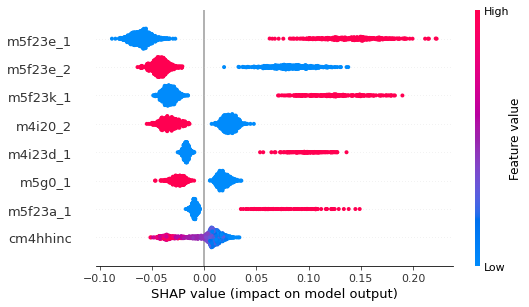

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

## Gradient Boosting

In [ ]:
model = joblib.load('models/material_xgb_200_.pkl')

In [ ]:
model.best_params_

{'model__regressor__xgboost__subsample': 0.6000000000000001,
 'model__regressor__xgboost__n_estimators': 180,
 'model__regressor__xgboost__min_child_weight': 7,
 'model__regressor__xgboost__max_depth': 10,
 'model__regressor__xgboost__learning_rate': 0.05250000000000004,
 'model__regressor__xgboost__gamma': 1.46,
 'model__regressor__xgboost__colsample_bytree': 0.6000000000000001,
 'model__regressor__xgboost__colsample_bylevel': 1.0,
 'model__regressor__sel__k': 5810,
 'model__regressor__normalize': RobustScaler(),
 'model__regressor__impute__strategy': 'mean'}

In [ ]:
variable = 'materialHardship'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
selector_k_best = SelectKBest(score_func=f_regression, k = 5810)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          subsample=0.6, 
                          n_estimators=180, 
                         min_child_weight=7,
                         max_depth=10,
                         learning_rate = 0.05,
                         gamma = 1.46, 
                         colsample_bytree = 0.6, 
                         colsample_bylevel = 1.0)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='median')), ('normalize', RobustScaler()), ('sel', selector_k_best), ('xgboost', xg_reg)])

model_pipe = Pipeline([('model', TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()))])

In [ ]:
boosting = model_pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
material_boosing_pred = boosting.predict(X_test)

In [ ]:
mean_squared_error(y_test,material_boosing_pred)

0.01993581223855128

In [ ]:
r2_score(y_test,material_boosing_pred)

0.19702783798948142

# Eviction

In [ ]:
from sklearn.linear_model import SGDClassifier
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import median_absolute_error, r2_score, brier_score_loss



## Elastic

In [ ]:
model = joblib.load('models/evic_logist_200.pkl')

In [ ]:
model.best_params_

{'sgd__l1_ratio': 0.0, 'sgd__alpha': 0.03, 'normalize': MinMaxScaler()}

In [ ]:
variable = 'eviction'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
sgd = SGDClassifier(loss='log', penalty='elasticnet', max_iter=10000, alpha=0.03, l1_ratio=0.0)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', StandardScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
eviction_elastic_pred = logistic.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,eviction_elastic_pred)

0.06504720600736875

In [ ]:
from sklearn.metrics import recall_score, precision_score


In [ ]:
binary_label = (eviction_elastic_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.06153846153846154

In [ ]:
precision_score(y_test, binary_label)

0.19047619047619047

## Random Forest

In [ ]:
model = joblib.load('models/evic_rf_200.pkl')

In [ ]:
model.best_params_

{'randomforest__n_estimators': 234,
 'randomforest__min_samples_split': 5,
 'randomforest__min_samples_leaf': 1,
 'randomforest__max_features': 'auto',
 'randomforest__max_depth': 25,
 'normalize': StandardScaler()}

In [ ]:
variable = 'eviction'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rfc = RandomForestClassifier(random_state=0,
                            n_estimators=234,
                            min_samples_split=5, 
                            min_samples_leaf= 1, 
                            max_features = 'auto',
                            max_depth = 25, 
                            )



In [ ]:
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', StandardScaler()), 
                           ('randomforest', rfc)])

In [ ]:
random_forest = pipeline.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
eviction_rf_pred = random_forest.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,eviction_rf_pred)

0.054969106819128616

In [ ]:
binary_label = (eviction_rf_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.0

In [ ]:
precision_score(y_test, binary_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

## Gradient Boosting

In [ ]:
model = joblib.load('models/evic_xgb_200.pkl')

In [ ]:
model.best_params_

{'xgboost__subsample': 0.4000000000000001,
 'xgboost__n_estimators': 230,
 'xgboost__min_child_weight': 7,
 'xgboost__max_depth': 3,
 'xgboost__learning_rate': 0.03350000000000002,
 'xgboost__gamma': 1.52,
 'xgboost__colsample_bytree': 0.7000000000000002,
 'xgboost__colsample_bylevel': 1.0,
 'impute__strategy': 'median',
 'feat_select__k': 7210}

In [ ]:
variable = 'eviction'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.4, 
                          n_estimators = 230, 
                          min_child_weight = 7, 
                          max_depth = 3, 
                          learning_rate = 0.03, 
                          gamma = 1.52, 
                          colsample_bytree = 0.7, 
                          colsample_bylevel = 1)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'median')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 7210)),
                           ('xgboost', xg_reg)])



In [ ]:
boosting = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  809   813   834 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:43:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
eviction_boosting_pred = boosting.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,eviction_boosting_pred)

0.0525810424580952

In [ ]:
binary_label = (eviction_boosting_pred >= 0.18) * 1

In [ ]:
recall_score(y_test, binary_label)

0.15384615384615385

In [ ]:
precision_score(y_test, binary_label)

0.18518518518518517

In [ ]:
import shap

In [ ]:
variable = 'eviction'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)

#minmaxscaler on X_values
minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.4, 
                          n_estimators = 230, 
                          min_child_weight = 7, 
                          max_depth = 3, 
                          learning_rate = 0.03, 
                          gamma = 1.52, 
                          colsample_bytree = 0.7, 
                          colsample_bylevel = 1)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
xg_reg.fit(X_train, y_train_trans)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[21:48:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=1.52, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=230, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
mybooster = xg_reg.get_booster()    

In [ ]:
model_bytearray = mybooster.save_raw()[4:]

In [ ]:
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [ ]:
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
vals= np.abs(shap_values).mean(0)

In [ ]:
vals

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
feature_importance = pd.DataFrame(list(zip(background.columns,vals)),columns=['Feature Name','Feature Importance Value'])
feature_importance.sort_values(by=['Feature Importance Value'],ascending=False,inplace=True)
feature_importance.set_index("Feature Name", inplace=True)


In [ ]:
print(feature_importance.iloc[0:8].to_latex())

\begin{tabular}{lr}
\toprule
{} &  Feature Importance Value \\
Feature Name &                           \\
\midrule
m5f23c\_1     &                  0.196777 \\
m5f23k\_1     &                  0.155438 \\
p5j10        &                  0.070845 \\
f3r4\_1       &                  0.062510 \\
m3i6a\_1      &                  0.055637 \\
m1j2b        &                  0.051535 \\
m5f7b\_1      &                  0.050427 \\
p3m18a\_2     &                  0.049570 \\
\bottomrule
\end{tabular}



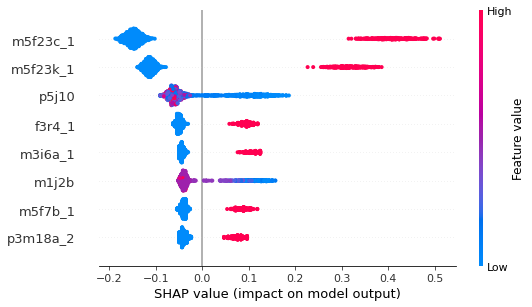

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

# Layoff

## Elastic

In [ ]:
model = joblib.load('models/layoff_logr_200.pkl')

In [ ]:
model.best_params_

{'sgd__l1_ratio': 0.55, 'sgd__alpha': 1.69, 'normalize': RobustScaler()}

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
sgd = SGDClassifier(loss='log', 
                    penalty='elasticnet', 
                    max_iter=10000, 
                    alpha=1.69, 
                    l1_ratio=0.55)

pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', RobustScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
layoff_elastic_pred = logistic.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,layoff_elastic_pred)

0.37631747835399165

In [ ]:
binary_label = (layoff_elastic_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.5118483412322274

In [ ]:
precision_score(y_test, binary_label)

0.21428571428571427

## Random Forest

In [ ]:
model = joblib.load('layoff_200_rf.pkl')

In [ ]:
model.best_params_

{'sel__k': 11710,
 'randomforest__n_estimators': 150,
 'randomforest__min_samples_split': 2,
 'randomforest__min_samples_leaf': 2,
 'randomforest__max_features': 'auto',
 'randomforest__max_depth': 15,
 'normalize': StandardScaler()}

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rfc = RandomForestClassifier(random_state=0, 
                            n_estimators = 150, 
                            min_samples_split = 2, 
                            min_samples_leaf = 2, 
                            max_features = 'auto', 
                            max_depth = 15)

In [ ]:
selector_k_best = SelectKBest(score_func=f_classif, k = 11710)


pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', "passthrough"),
                           ('sel', selector_k_best),
                           ('randomforest', rfc)])

In [ ]:
rf = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  809   813   834 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
layoff_rf_pred = rf.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,layoff_rf_pred)

0.16826965167406932

In [ ]:
binary_label = (layoff_rf_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.0

In [ ]:
precision_score(y_test, binary_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

## Gradient Boosting

In [ ]:
model = joblib.load('models/layoff_xgb_200.pkl')

In [ ]:
model.best_params_

{'xgboost__subsample': 0.5000000000000001,
 'xgboost__n_estimators': 290,
 'xgboost__min_child_weight': 5,
 'xgboost__max_depth': 8,
 'xgboost__learning_rate': 0.09750000000000007,
 'xgboost__gamma': 1.44,
 'xgboost__colsample_bytree': 0.3,
 'xgboost__colsample_bylevel': 0.0,
 'impute__strategy': 'mean',
 'feat_select__k': 6010}

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.5, 
                          n_estimators = 290, 
                          min_child_weight = 5, 
                          max_depth = 8, 
                          learning_rate = 0.097, 
                          gamma = 1.44, 
                          colsample_bytree = 0.3, 
                          colsample_bylevel = 0)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'mean')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 6010)),
                           ('xgboost', xg_reg)])



In [ ]:
boosting = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  809   813   834 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
layoff_boosting_pred = boosting.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,layoff_boosting_pred)

0.16693356536060125

In [ ]:
binary_label = (layoff_boosting_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.0

In [ ]:
precision_score(y_test, binary_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
import shap

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)

#minmaxscaler on X_values
minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.5, 
                          n_estimators = 290, 
                          min_child_weight = 5, 
                          max_depth = 8, 
                          learning_rate = 0.097, 
                          gamma = 1.44, 
                          colsample_bytree = 0.3, 
                          colsample_bylevel = 0)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
xg_reg.fit(X_train, y_train_trans)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:07:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0,
              colsample_bynode=1, colsample_bytree=0.3, gamma=1.44, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.097, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=290, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
mybooster = xg_reg.get_booster()    

In [ ]:
model_bytearray = mybooster.save_raw()[4:]

In [ ]:
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [ ]:
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


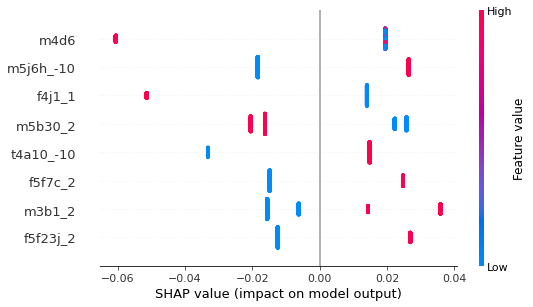

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

# JobTraining

## Elastic

In [ ]:
model = joblib.load('models/jobtrain_logr_200.pkl')

In [ ]:
model.best_params_

{'sgd__l1_ratio': 0.66,
 'sgd__alpha': 1.9200000000000002,
 'normalize': RobustScaler()}

In [ ]:
variable = 'jobTraining'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
sgd = SGDClassifier(loss='log', 
                    penalty='elasticnet', 
                    max_iter=10000, 
                    alpha=1.92, 
                    l1_ratio=0.66)
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()),
                           ('normalize', RobustScaler()), 
                           ('sgd', sgd)])


In [ ]:
logistic = pipeline.fit(X_train, y_train)

In [ ]:
variable = 'jobTraining'
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
len(y_test)

1104

In [ ]:
jobtrain_elastic_pred = logistic.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,jobtrain_elastic_pred)

0.2252425795452132

In [ ]:
binary_label = (jobtrain_elastic_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.2952029520295203

In [ ]:
precision_score(y_test, binary_label)

0.3292181069958848

## Random Forest

In [ ]:
model = joblib.load('models/jobtrain_rf_new200_.pkl')

In [ ]:
model.best_params_

{'sel__k': 11710,
 'randomforest__n_estimators': 150,
 'randomforest__min_samples_split': 2,
 'randomforest__min_samples_leaf': 2,
 'randomforest__max_features': 'auto',
 'randomforest__max_depth': 15,
 'normalize': StandardScaler()}

In [ ]:
variable = 'layoff'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
rfc = RandomForestClassifier(random_state=0, 
                            n_estimators = 132, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1, 
                            max_features = 'auto', 
                            max_depth = 25)

In [ ]:
pipeline = Pipeline(steps=[('impute', SimpleImputer()),
                           ('sampling', SMOTE()), 
                           ('normalize', StandardScaler()), 
                           ('randomforest', rfc)])

In [ ]:
rf = pipeline.fit(X_train, y_train)

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
layoff_rf_pred = rf.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test,layoff_rf_pred)

0.16921346649667565

In [ ]:
binary_label = (layoff_rf_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.0

In [ ]:
precision_score(y_test, binary_label)

0.0

In [ ]:
import shap

In [ ]:
variable = 'jobTraining'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
#fill NAs 
means_train = X_train.mean()
X_train = X_train.fillna(means_train)
X_test = X_test.fillna(means_train)


#minmaxscaler on X_values
robust = RobustScaler()
X_train = robust.fit_transform(X_train)
X_test = robust.transform(X_test)

rfc = RandomForestClassifier(random_state=0, 
                            n_estimators = 132, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1, 
                            max_features = 'auto', 
                            max_depth = 25)

In [ ]:
yscale = StandardScaler()
y_train_trans = yscale.fit_transform(np.array(y_train).reshape(len(y_train), 1))

In [ ]:
rf.fit(X_train, y_train_trans)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=16, min_samples_leaf=8, min_samples_split=8,
                      n_estimators=238, random_state=0)

In [ ]:
shap_ex = shap.TreeExplainer(rf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


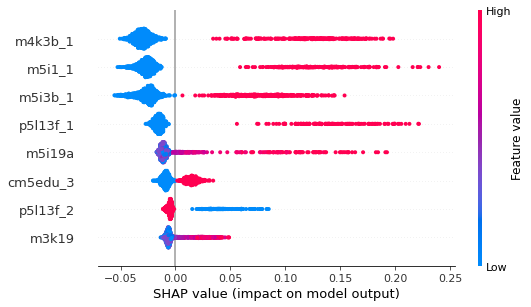

In [ ]:
shap_values = shap_ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=list(background), max_display=8)

## Gradient Boosting

In [ ]:
model = joblib.load('models/jobtrain_xgb_200.pkl')

In [ ]:
model.best_params_

{'xgboost__subsample': 0.7000000000000002,
 'xgboost__n_estimators': 130,
 'xgboost__min_child_weight': 1,
 'xgboost__max_depth': 4,
 'xgboost__learning_rate': 0.035500000000000025,
 'xgboost__gamma': 1.95,
 'xgboost__colsample_bytree': 0.6000000000000001,
 'xgboost__colsample_bylevel': 1.0,
 'impute__strategy': 'median',
 'feat_select__k': 2110}

In [ ]:
variable = 'jobTraining'
X_train = background.loc[train.index]
y_train = train[variable].dropna()
X_train = X_train.loc[y_train.index.values]

In [ ]:

xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           subsample = 0.7, 
                          n_estimators = 130, 
                          min_child_weight = 1, 
                          max_depth = 4, 
                          learning_rate = 0.03, 
                          gamma = 1.95, 
                          colsample_bytree = 0.6, 
                          colsample_bylevel = 1)

pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy = 'median')),
                           ('normalize', MinMaxScaler()), 
                           ('feat_select', SelectKBest(f_classif, k = 2210)),
                           ('xgboost', xg_reg)])



In [ ]:
boosting = pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  809   813   834 ... 29363 29383 29423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
X_test = background.loc[test.index]
y_test = test[variable].dropna()
X_test = X_test.loc[y_test.index.values]

In [ ]:
y_test = np.array(y_test * 1).astype(int)

In [ ]:
jobtraining_boosting_pred = boosting.predict_proba(X_test)[:, 1]

In [ ]:
brier_score_loss(y_test, jobtraining_boosting_pred)

0.17748070145038836

In [ ]:
binary_label = (jobtraining_boosting_pred >= 0.5) * 1

In [ ]:
recall_score(y_test, binary_label)

0.05904059040590406

In [ ]:
precision_score(y_test, binary_label)

0.48484848484848486